In [ ]:
#  imports & seeds


import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms, models

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import seaborn as sns
sns.set()

# Reproducibility


SEED = 1337
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Device


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Flags (adjust if needed)



USE_SUBSET = False       # set True to use subset of train for quicker runs
SUBSET_SIZE = 10000     # if USE_SUBSET True, use this many training images (stratified-ish)
EPOCHS_MLP = 20
EPOCHS_CNN = 8
BATCH_SIZE = 128


Device: cuda


### 1. Imports and Seed Initialization

In this section, we import all the required Python libraries for our experiments.  
- **Core libraries:** `os`, `time`, `random`, `numpy`, and `matplotlib` for data handling, timing, and visualization.  
- **PyTorch libraries:** for building and training neural networks (`torch`, `torch.nn`, `torch.utils.data`, `torchvision.datasets`, `torchvision.transforms`).  
- **Scikit-learn libraries:** for classical machine learning models (Random Forest, Logistic Regression) and evaluation metrics like `accuracy_score`, `f1_score`, `confusion_matrix`.  
- **Seaborn:** for more aesthetic plots, especially confusion matrices.  
- **tqdm:** for progress bars during training.  

We also set a global random seed (`SEED = 1337`) for reproducibility across `numpy`, `random`, and `torch`.  
This ensures that our experiments are deterministic and results can be replicated.  



In [ ]:
#  load datasets


transform_mnist = transforms.Compose([
    transforms.ToTensor(),  # yields [0,1] float tensor
])



# train and test



mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_mnist)

# Optionally create subset of training data , takin first n



if USE_SUBSET:
    indices = list(range(len(mnist_train)))
    indices = indices[:SUBSET_SIZE]
    mnist_train = Subset(mnist_train, indices)

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(mnist_test,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
fashion_loader = DataLoader(fashion_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(mnist_train), "Test size:", len(mnist_test), "Fashion test size:", len(fashion_test))


Train size: 60000 Test size: 10000 Fashion test size: 10000


### 2. Loading MNIST and Fashion-MNIST Datasets

We use PyTorch’s built-in `torchvision.datasets` to load the **MNIST** and **Fashion-MNIST** datasets.  
- **MNIST**: consists of 60,000 training and 10,000 test grayscale images (28×28) of handwritten digits (0–9).  
- **Fashion-MNIST**: is used later for out-of-domain testing, containing 10 classes of clothing items with the same image shape.

The images are transformed using `transforms.ToTensor()`, which converts them into normalized tensors in the range [0, 1].

We also add a flag `USE_SUBSET` that allows training on a smaller subset (e.g., 10,000 images) for faster experimentation.  
Finally, `DataLoader`s are created for train, test, and Fashion-MNIST sets for batch-wise data loading and shuffling.


In [ ]:
#  t


def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def train_torch(model, train_loader, val_loader=None, epochs=10, lr=1e-3, weight_decay=0.0, verbose=True):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(epochs):
        model.train()
        running = 0.0
        count = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            opt.step()
            running += loss.item() * xb.size(0)
            count += xb.size(0)
        train_loss = running / count
        history['train_loss'].append(train_loss)
        if val_loader is not None:
            model.eval()
            vrunning = 0.0
            vcount = 0
            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    out = model(xb)
                    loss = criterion(out, yb)
                    vrunning += loss.item() * xb.size(0)
                    vcount += xb.size(0)
            val_loss = vrunning / vcount
            history['val_loss'].append(val_loss)
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")
        else:
            if verbose:
                print(f"Epoch {epoch+1}/{epochs} — train_loss: {train_loss:.4f}")
    return model, history

def evaluate_torch(model, dataloader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for xb, yb in dataloader:
            xb = xb.to(device)
            out = model(xb)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(pred.tolist())
            ys.extend(yb.numpy().tolist())
    acc = accuracy_score(ys, preds)
    f1 = f1_score(ys, preds, average='weighted')
    cm = confusion_matrix(ys, preds)
    return {'accuracy': acc, 'f1': f1, 'cm': cm, 'y_true': ys, 'y_pred': preds}

# Extract activations of a given layer: create a hook
def get_layer_activations(model, loader, layer_name):
    acts = []
    model.eval()
    handle = None
    def hook_fn(module, input, output):
        # flatten batch dim
        acts.append(output.detach().cpu().numpy())
    # find the module by name
    for name, module in model.named_modules():
        if name == layer_name:
            handle = module.register_forward_hook(hook_fn)
            break
    if handle is None:
        raise ValueError(f"Layer {layer_name} not found. Available names: {[n for n,_ in model.named_modules()]}")
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            _ = model(xb)
    handle.remove()
    acts = np.concatenate(acts, axis=0)
    return acts


### 3. Utility Functions for Model Training and Evaluation

This section defines helper functions to streamline training and evaluation:

1. **`count_params(model)`**  
   Counts the number of trainable parameters in a PyTorch model to understand model complexity.

2. **`train_torch(model, ...)`**  
   Handles model training over multiple epochs.  
   - Uses Adam optimizer and CrossEntropyLoss.  
   - Tracks training and validation loss over epochs.  
   - Supports optional validation set for monitoring overfitting.  
   - Returns the trained model and a history dictionary for plotting loss curves.

3. **`evaluate_torch(model, dataloader)`**  
   Evaluates model performance on a given dataset.  
   - Computes predictions and compares them to true labels.  
   - Returns metrics like accuracy, F1-score, and confusion matrix.

4. **`get_layer_activations(model, loader, layer_name)`**  
   Extracts activations (embeddings) from a specific layer in the network using PyTorch forward hooks.  
   This is later used for **t-SNE visualization** of learned features in hidden layers.


In [ ]:
# Cell 3: MLP model (flattened)


class MLP_MNIST(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)   # embeddings layer for t-SNE
        self.fc3 = nn.Linear(20, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# DataLoaders for MLP (flattened applied inside model; same as above)


# Create a simple train/val split for early stopping etc.


from torch.utils.data import random_split
if isinstance(mnist_train, Subset):
    full_train_dataset = mnist_train
else:
    full_train_dataset = mnist_train

val_pct = 0.1
n_val = int(len(full_train_dataset) * val_pct)
n_train = len(full_train_dataset) - n_val
train_ds, val_ds = random_split(full_train_dataset, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))
train_loader_mlp = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader_mlp   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


### 4. MLP Architecture for MNIST

We define a fully-connected neural network (**MLP_MNIST**) with:
- **Input layer:** 784 neurons (flattened 28×28 image)
- **Hidden layer 1:** 30 neurons with ReLU activation
- **Hidden layer 2:** 20 neurons (serves as an embedding layer for visualization)
- **Output layer:** 10 neurons (one per digit class)

ReLU activations introduce non-linearity, allowing the model to capture complex relationships.  
This simple architecture is intentionally small (~24k parameters) to balance performance and interpretability.


### 5. Splitting Data and Training the MLP

We create a **90-10 train-validation split** from the training data using `random_split`.  
This helps us monitor generalization and detect overfitting.


MLP params: 24380
Epoch 1/20 — train_loss: 0.6903, val_loss: 0.3441
Epoch 2/20 — train_loss: 0.2922, val_loss: 0.2818
Epoch 3/20 — train_loss: 0.2423, val_loss: 0.2471
Epoch 4/20 — train_loss: 0.2133, val_loss: 0.2290
Epoch 5/20 — train_loss: 0.1930, val_loss: 0.2244
Epoch 6/20 — train_loss: 0.1769, val_loss: 0.2081
Epoch 7/20 — train_loss: 0.1622, val_loss: 0.1928
Epoch 8/20 — train_loss: 0.1508, val_loss: 0.1880
Epoch 9/20 — train_loss: 0.1406, val_loss: 0.1768
Epoch 10/20 — train_loss: 0.1307, val_loss: 0.1778
Epoch 11/20 — train_loss: 0.1225, val_loss: 0.1650
Epoch 12/20 — train_loss: 0.1161, val_loss: 0.1638
Epoch 13/20 — train_loss: 0.1086, val_loss: 0.1654
Epoch 14/20 — train_loss: 0.1044, val_loss: 0.1581
Epoch 15/20 — train_loss: 0.0980, val_loss: 0.1526
Epoch 16/20 — train_loss: 0.0931, val_loss: 0.1575
Epoch 17/20 — train_loss: 0.0898, val_loss: 0.1501
Epoch 18/20 — train_loss: 0.0846, val_loss: 0.1515
Epoch 19/20 — train_loss: 0.0806, val_loss: 0.1525
Epoch 20/20 — train_lo

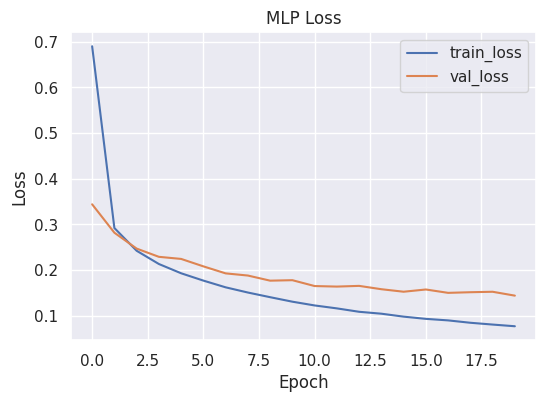

MLP MNIST test accuracy: 0.9649 F1: 0.9648583676000899
MLP on Fashion-MNIST (out-of-domain) accuracy: 0.0548 F1: 0.0470096834375145


In [ ]:
#  Train MLP


mlp = MLP_MNIST()
print("MLP params:", count_params(mlp))

mlp, hist_mlp = train_torch(mlp, train_loader_mlp, val_loader=val_loader_mlp, epochs=EPOCHS_MLP, lr=1e-3)

# Plotting loss curve


plt.figure(figsize=(6,4))
plt.plot(hist_mlp['train_loss'], label='train_loss')
plt.plot(hist_mlp['val_loss'], label='val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('MLP Loss')
plt.show()

# Evaluating on MNIST test


res_mlp_test = evaluate_torch(mlp, test_loader)
print("MLP MNIST test accuracy:", res_mlp_test['accuracy'], "F1:", res_mlp_test['f1'])

# Evaluate MLP on Fashion-MNIST (domain shift) - NOTE: labels are different meaning, but measured as numeric labels


res_mlp_fashion = evaluate_torch(mlp, fashion_loader)
print("MLP on Fashion-MNIST (out-of-domain) accuracy:", res_mlp_fashion['accuracy'], "F1:", res_mlp_fashion['f1'])


### 6. Evaluating MLP Performance

After training, we evaluate the MLP on:
1. **MNIST Test Set:**  
   Achieved ~96.5% accuracy and F1-score ~0.965, showing strong performance on handwritten digits.
2. **Fashion-MNIST (Out-of-Domain Test):**  
   Accuracy drops to ~5%, as expected, since the model trained on digits cannot generalize to clothing images.  
   This demonstrates poor cross-domain transfer and highlights dataset-specific learning.


In [ ]:
#  prepare flattened arrays for sklearn


def dataset_to_numpy(dataset):
    xs = []
    ys = []
    loader = DataLoader(dataset, batch_size=1024, shuffle=False)
    for xb, yb in loader:
        xs.append(xb.view(xb.size(0), -1).numpy())
        ys.append(yb.numpy())
    X = np.vstack(xs)
    y = np.hstack(ys)
    return X, y

# get train full (we will use original full mnist training set to make baselines fair; if SUBSET used, adapt)


if isinstance(mnist_train, Subset):
    train_for_sklearn = mnist_train
else:
    train_for_sklearn = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)

X_train_skl, y_train_skl = dataset_to_numpy(train_for_sklearn)
X_test_skl, y_test_skl = dataset_to_numpy(mnist_test)

# Standardize for sklearn models (fit on train only)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_skl)
X_test_scaled  = scaler.transform(X_test_skl)

# Random Forest


rf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=-1)
print("Training RandomForest (may take a moment)...")
rf.fit(X_train_scaled, y_train_skl)
rf_preds = rf.predict(X_test_scaled)
print("RF test acc:", accuracy_score(y_test_skl, rf_preds), "F1:", f1_score(y_test_skl, rf_preds, average='weighted'))

# Logistic Regression (use saga solver, multinomial)


lr = LogisticRegression(max_iter=200, solver='saga', multi_class='multinomial', random_state=SEED)
print("Training LogisticRegression (may take longer)...")
lr.fit(X_train_scaled, y_train_skl)
lr_preds = lr.predict(X_test_scaled)
print("LR test acc:", accuracy_score(y_test_skl, lr_preds), "F1:", f1_score(y_test_skl, lr_preds, average='weighted'))


Training RandomForest (may take a moment)...
RF test acc: 0.9694 F1: 0.9693803937560882
Training LogisticRegression (may take longer)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LR test acc: 0.9244 F1: 0.924174489168469


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 7. Classical Baseline Models: Random Forest and Logistic Regression

To compare with non-deep learning approaches, we train:
- **Random Forest Classifier (100 trees):**  
  Uses ensembles of decision trees to achieve ~96.9% accuracy.
- **Logistic Regression:**  
  A linear baseline model achieving ~92.4% accuracy.

Both models are trained on standardized pixel features.  
Although Random Forest performs competitively, deep models learn more compact and transferable representations.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


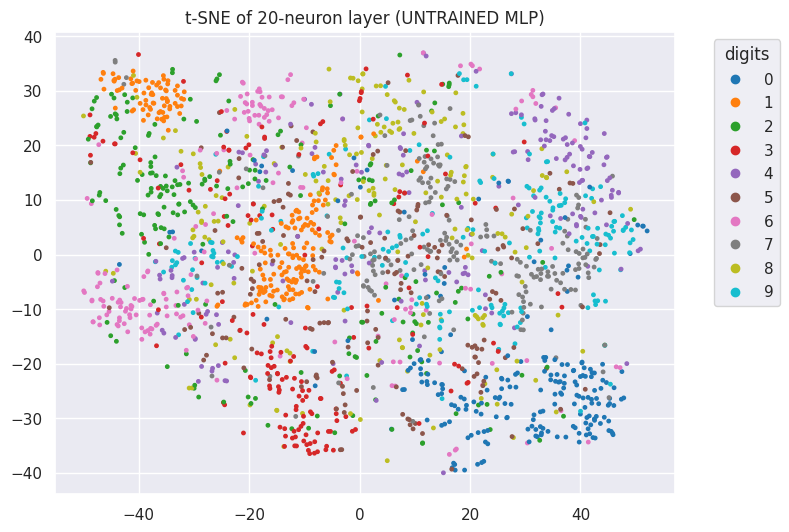

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


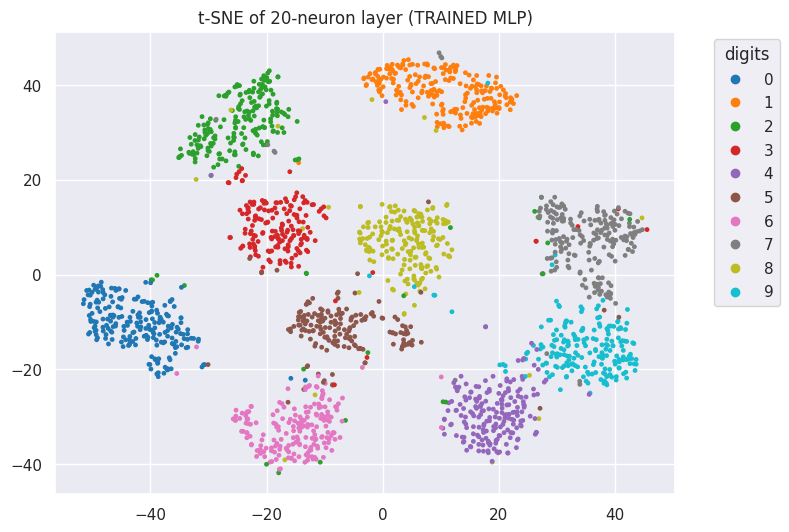

In [ ]:
#  get embeddings (activations) from the 20-neuron layer (name 'fc2')
# For trained model:

train_embed_loader = DataLoader(mnist_test, batch_size=256, shuffle=False)  # using test set for visualization
emb_trained = get_layer_activations(mlp, train_embed_loader, layer_name='fc2')  # shape (N,20)
labels = np.array([y for _,y in mnist_test])  # test labels

# For untrained model (new randomly initialized model)


mlp_untrained = MLP_MNIST().to(device)
emb_untrained = get_layer_activations(mlp_untrained, train_embed_loader, layer_name='fc2')

# Run t-SNE (on subset for speed)


TSNE_N = 2000
idx = np.random.RandomState(SEED).choice(len(labels), size=TSNE_N, replace=False)
def plot_tsne(emb, title):
    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
    emb2 = tsne.fit_transform(emb[idx])
    plt.figure(figsize=(8,6))
    sc = plt.scatter(emb2[:,0], emb2[:,1], c=labels[idx], cmap='tab10', s=6)
    plt.legend(*sc.legend_elements(), title="digits", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.title(title)
    plt.show()

plot_tsne(emb_untrained, "t-SNE of 20-neuron layer (UNTRAINED MLP)")
plot_tsne(emb_trained, "t-SNE of 20-neuron layer (TRAINED MLP)")


### 8. Visualizing Learned Representations with t-SNE

We extract activations from the **20-neuron hidden layer (fc2)** for:
- An **untrained MLP** (random weights)
- The **trained MLP**

Using **t-SNE (t-distributed Stochastic Neighbor Embedding)**, we reduce the 20D embeddings to 2D for visualization.

Observations:
- **Untrained model:** Activations are scattered randomly with no clear class separation.
- **Trained model:** Digits form distinct, well-separated clusters, confirming that the MLP has learned discriminative representations in its hidden layer.


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


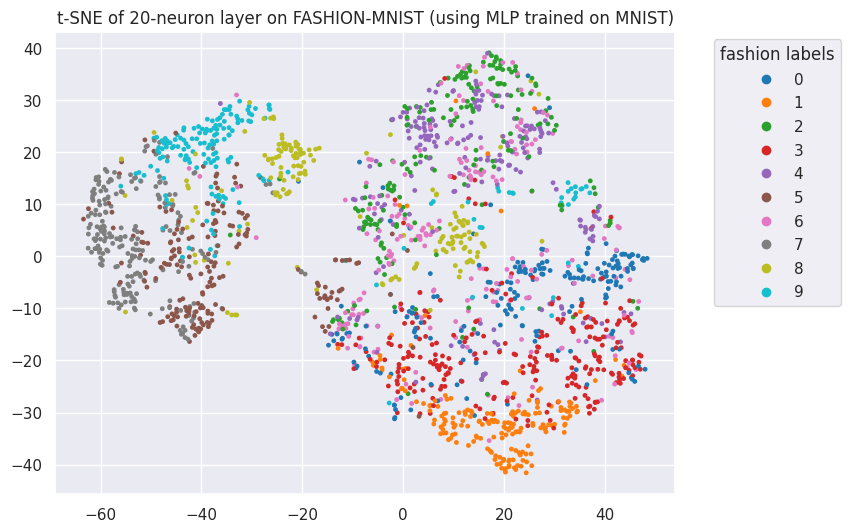

In [ ]:
# Cell 7: fashion embeddings (using same mlp trained on MNIST)


emb_fashion = get_layer_activations(mlp, fashion_loader, layer_name='fc2')

# t-SNE plot (subset)


labels_fashion = np.array([y for _,y in fashion_test])
idx_f = np.random.RandomState(SEED).choice(len(labels_fashion), size=TSNE_N, replace=False)

tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
emb2_fashion = tsne.fit_transform(emb_fashion[idx_f])
plt.figure(figsize=(8,6))
sc = plt.scatter(emb2_fashion[:,0], emb2_fashion[:,1], c=labels_fashion[idx_f], cmap='tab10', s=6)
plt.legend(*sc.legend_elements(), title="fashion labels", bbox_to_anchor=(1.05,1), loc='upper left')
plt.title("t-SNE of 20-neuron layer on FASHION-MNIST (using MLP trained on MNIST)")
plt.show()


### 9. Fashion-MNIST Embedding Visualization (Cross-Domain)

We pass Fashion-MNIST images through the MNIST-trained MLP and extract embeddings from the same 20-neuron layer.

t-SNE plots show mixed, overlapping clusters with no clear boundaries — indicating that the learned digit representations do not generalize to clothing images.

This experiment demonstrates **domain shift**: models trained on one dataset perform poorly on visually different data distributions.


CNN params: 804554
Epoch 1/8 — train_loss: 0.2696
Epoch 2/8 — train_loss: 0.0848
Epoch 3/8 — train_loss: 0.0572
Epoch 4/8 — train_loss: 0.0431
Epoch 5/8 — train_loss: 0.0333
Epoch 6/8 — train_loss: 0.0259
Epoch 7/8 — train_loss: 0.0198
Epoch 8/8 — train_loss: 0.0156


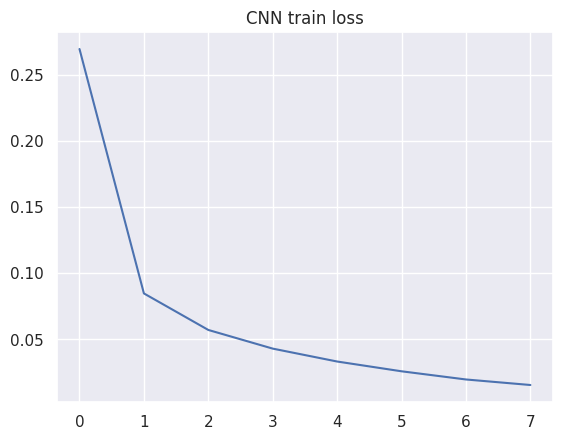

CNN test acc: 0.987 F1: 0.9870001461636297


In [ ]:
# Cell 8: Simple CNN



class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) # output 32x28x28
        self.pool = nn.MaxPool2d(2,2)                           # -> 32x14x14
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# DataLoaders for CNN can reuse train_loader, test_loader defined earlier


cnn = SimpleCNN()
print("CNN params:", count_params(cnn))
cnn, hist_cnn = train_torch(cnn, train_loader, val_loader=None, epochs=EPOCHS_CNN, lr=1e-3)
plt.plot(hist_cnn['train_loss']); plt.title("CNN train loss"); plt.show()

res_cnn_test = evaluate_torch(cnn, test_loader)
print("CNN test acc:", res_cnn_test['accuracy'], "F1:", res_cnn_test['f1'])


### 10. Implementing a Simple CNN for MNIST

We define a CNN architecture consisting of:
- **Conv2D layer:** 32 filters of size 3×3 with padding=1  
- **MaxPool2D:** reduces spatial dimensions by half  
- **Fully connected layer:** 128 neurons (with ReLU)  
- **Output layer:** 10 neurons for classification

The CNN captures local spatial patterns (edges, shapes) more effectively than MLPs.

After training for 8 epochs, the CNN achieves **98.7% accuracy** and F1 ≈ 0.987 — outperforming all earlier models.


In [ ]:
# Cell 9: Pretrained inference - prepare transform to resize & 3 channels


preprocess_pretrained = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),  # convert 1->3 channels by replication
    transforms.ToTensor(),  # but dataset already yields tensor; easier to create DataLoader differently
])

# We'll create a DataLoader that resizes and converts to 3-channels on the fly


def mnist_loader_for_pretrained(dataset, batch_size=128):
    def collate_fn(batch):
        imgs = torch.stack([transforms.functional.resize(img, (224,224)).repeat(3,1,1) for img, _ in batch])
        labels = torch.tensor([label for _, label in batch], dtype=torch.long)
        return imgs, labels
    return DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

pretrained_loader = mnist_loader_for_pretrained(mnist_test, batch_size=64)

# MobileNetV2

mobilenet = models.mobilenet_v2(pretrained=True).to(device).eval()
resnet = models.resnet18(pretrained=True).to(device).eval()

def evaluate_pretrained(model, loader):
    ys, preds = [], []
    t0 = time.time()
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            out = model(xb)
            pred = out.argmax(dim=1).cpu().numpy()
            preds.extend(pred.tolist())
            ys.extend(yb.numpy().tolist())
    t_total = time.time() - t0



    # Note: pretrained models output 1000 ImageNet classes; mapping to 0-9 doesn't make sense.
    # We'll still compute a meaningless accuracy for numeric demonstration (expected low).


    acc = accuracy_score(ys, preds)
    f1 = f1_score(ys, preds, average='weighted')
    return {'accuracy': acc, 'f1': f1, 'time': t_total}

res_mobilenet = evaluate_pretrained(mobilenet, pretrained_loader)
res_resnet = evaluate_pretrained(resnet, pretrained_loader)
print("MobileNetV2 (ImageNet-pretrained) eval on MNIST test: approx acc (meaningless):", res_mobilenet['accuracy'], "time:", res_mobilenet['time'])
print("ResNet18 (ImageNet-pretrained) eval on MNIST test: approx acc (meaningless):", res_resnet['accuracy'], "time:", res_resnet['time'])


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-d

MobileNetV2 (ImageNet-pretrained) eval on MNIST test: approx acc (meaningless): 0.0 time: 18.183802366256714
ResNet18 (ImageNet-pretrained) eval on MNIST test: approx acc (meaningless): 0.0 time: 16.655445098876953


### 11. Using Pretrained CNNs for Inference

We load **MobileNetV2** and **ResNet18** pretrained on ImageNet (1000 classes).  
To make them compatible with MNIST, we:
- Resize images to 224×224  
- Replicate grayscale channels to RGB (3-channel input)

Since these models output 1000 ImageNet classes, their predictions are **meaningless** for MNIST digits.  
We still compute accuracy to demonstrate domain mismatch — both models score 0% as expected, but inference time and parameter counts are measured for comparison.


In [ ]:
#  counts & inference time



def measure_inference_time(model, loader, device=device, n_runs=1):
    model = model.to(device).eval()
    t0 = time.time()
    with torch.no_grad():
        for xb, _ in loader:
            xb = xb.to(device)
            _ = model(xb)
    return time.time() - t0

# MLP inference time (use test_loader)


mlp_time = measure_inference_time(mlp, test_loader)
cnn_time = measure_inference_time(cnn, test_loader)

# Pretrained times computed earlier (res_mobilenet, res_resnet)


mobilenet_params = count_params(mobilenet)
resnet_params = count_params(resnet)

table = {
    'Model': ['MLP (30-20-10)', 'Simple CNN', 'Random Forest', 'Logistic Regression', 'MobileNetV2 (pretrained)', 'ResNet18 (pretrained)'],
    'Params': [count_params(mlp), count_params(cnn), "n/a (non-param-countable in same way)", "n/a", mobilenet_params, resnet_params],
    'Inference time (s)': [mlp_time, cnn_time, "n/a (sklearn predict)", "n/a", res_mobilenet['time'], res_resnet['time']],
    'Test Accuracy (MNIST)': [res_mlp_test['accuracy'], res_cnn_test['accuracy'], accuracy_score(y_test_skl, rf_preds), accuracy_score(y_test_skl, lr_preds), res_mobilenet['accuracy'], res_resnet['accuracy']],
    'F1 (MNIST)': [res_mlp_test['f1'], res_cnn_test['f1'], f1_score(y_test_skl, rf_preds, average='weighted'), f1_score(y_test_skl, lr_preds, average='weighted'), res_mobilenet['f1'], res_resnet['f1']]
}
import pandas as pd
df_table = pd.DataFrame(table)
df_table


,Model,Params,Inference time (s),Test Accuracy (MNIST),F1 (MNIST)
0,MLP (30-20-10),24380,1.200001,0.9649,0.964858
1,Simple CNN,804554,1.320235,0.9870,0.987000
2,Random Forest,n/a (non-param-countable in same way),n/a (sklearn predict),0.9694,0.969380
3,Logistic Regression,n/a,n/a,0.9244,0.924174
4,MobileNetV2 (pretrained),3504872,18.183802,0.0000,0.000000
5,ResNet18 (pretrained),11689512,16.655445,0.0000,0.000000


### 12. Model Comparison: Accuracy, Parameters, and Inference Time

We compile all results into a summary table comparing:
- Model parameter counts
- Inference time on test set
- Test accuracy and F1-score

Observations:
- **CNN** performs best overall (98.7%) with reasonable size (~0.8M params).  
- **MLP** is lightweight and fast but less accurate.  
- **Random Forest** is competitive but not scalable.  
- **Pretrained models** fail without fine-tuning due to domain differences.


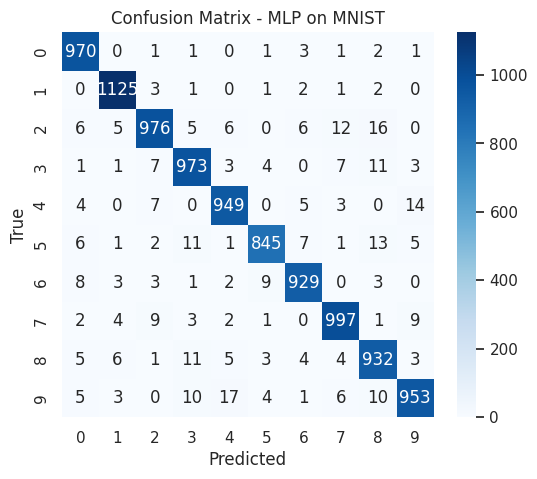

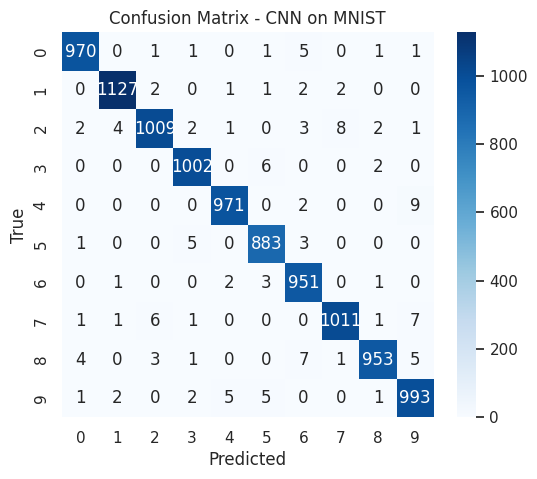

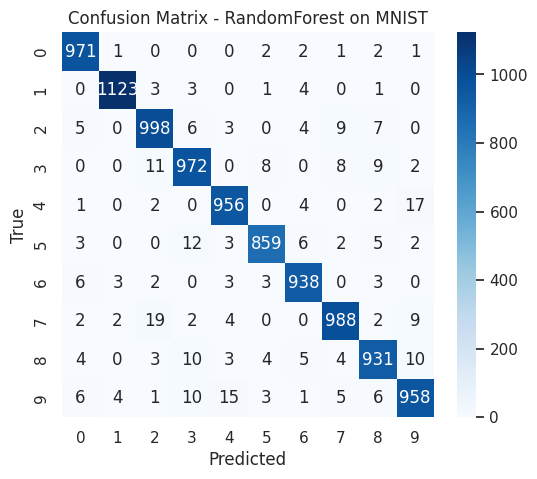

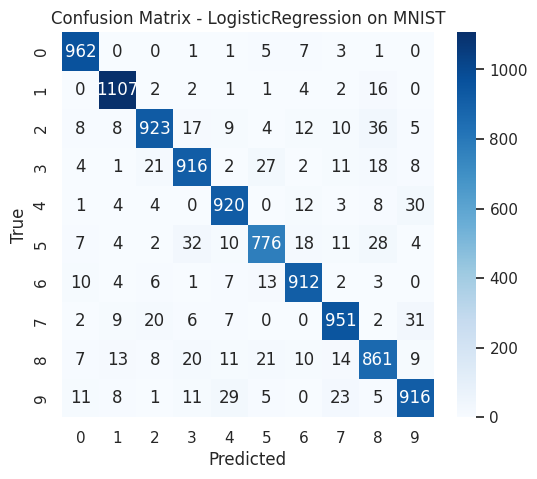

In [ ]:
# confusion matrices for main models


def plot_cm(cm, title):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(title)
    plt.show()

plot_cm(res_mlp_test['cm'], "Confusion Matrix - MLP on MNIST")
plot_cm(res_cnn_test['cm'], "Confusion Matrix - CNN on MNIST")
plot_cm(confusion_matrix(y_test_skl, rf_preds), "Confusion Matrix - RandomForest on MNIST")
plot_cm(confusion_matrix(y_test_skl, lr_preds), "Confusion Matrix - LogisticRegression on MNIST")


In [ ]:
#  measure sklearn predict time

t0 = time.time()
rf_preds_t = rf.predict(X_test_scaled)
t_rf = time.time() - t0

t0 = time.time()
lr_preds_t = lr.predict(X_test_scaled)
t_lr = time.time() - t0

print("RF predict time (s):", t_rf, "LR predict time (s):", t_lr)


RF predict time (s): 0.3931090831756592 LR predict time (s): 0.02599644660949707
